# Blood sugar fast day

I am type 1 diabetic and require a constant monitoring of my glycemia (the concentration of glucose in my blood) in order to treat myself. I wear a continuous glucose monitor at all times and my glycemia is measured every 5 minutes. The goal of the treatment is to keep the glycemia in range. This is done by balancing the glucose intake (basically food) with insulin shots. At the beginning of July 2024, I did a 24 hours fast. This provided me with simplified data to analyse. Indeed, en everyday life, the three main components of diabetes treatment insulin, glucose and exercise, all happen together. For example, I inject insulin just before I eat my lunch so that both components compensate each other. In this simplified data set, I have 6 events where only one of the components is acting, independently from the others.

In this project, I analyse these events with a focus on time scales. In particular, I measure the time-scales on which each components affects my glycemia. In the first section, I extract and prepare the relevant data from the excel file provided by the manufacturer of my glycemia sensor. The data is saved into a *.csv file that is used in the rest of the notebook. In the second part, I look at the effect of an insulin shot on my glycemia over time. In particular, I introduce a model for the insulin action over time and measure the corresponding time scales by fitting the model. The third part is similar to the second, but with the effect of glucose intake. In the fourth part, I look at the effect of exercise and draw a simple qualitative conclusion. Finally I look at the long acting insulin and it's action over time in part five.

## 1. Data preparation

In this section I import the data provided by my sensor from an excel file into a single DataFrame. I implement a smooth glycemia re-calibration and I select the data corresponding to my fast day.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

all_data = pd.read_excel('All Events.xlsx',sheet_name = 'Sensor Glucose').drop(columns = ['SensorID','UnitMeasureVal'])
# I'm only interested in 2 days of data. Cut out most of the data immediately.
date_window = [datetime(2024,7,1),datetime(2024,7,6)]
all_data['EventDateStr'] = pd.to_datetime(all_data['EventDateStr'])
all_data = all_data[(all_data['EventDateStr']>=date_window[0]) & (all_data['EventDateStr']<=date_window[-1])].copy()
all_data['EventType'] = 'glycemia'

#include the insulin injection, eating and sport events
temp = pd.read_excel('All Events.xlsx',sheet_name = 'Patient Events')
temp['EventDateStr'] = pd.to_datetime(temp['EventDateStr'])
temp = temp[(temp['EventDateStr']>=date_window[0]) & (temp['EventDateStr']<=date_window[-1])].copy()
temp.loc[temp['EventType'] == 'Insulin','UnitValue'] = temp.loc[temp['EventType'] == 'Insulin','UnitValue'].apply(lambda x: x[:-6])
temp.loc[temp['EventType'] == 'Meal','UnitValue'] = temp.loc[temp['EventType'] == 'Meal','UnitValue'].apply(lambda x: x[7:-6])
temp.loc[temp['EventType'] == 'Exercise','UnitValue'] = temp.loc[temp['EventType'] == 'Exercise','UnitValue'].apply(lambda x: x[10:-4])
temp.loc[temp['EventSubType'] == 'Type: Rapid Acting','EventType'] = 'rapid_insulin_u'
temp.loc[temp['EventSubType'] == 'Type: Long Acting','EventType'] = 'long_insulin_u'
# I took note of what I ate (sugar, chocolate, sugar, sugar), but had to look is up in my phone.
temp.loc[temp['EventType'] == 'Meal','EventType'] = ['rapid_glucose_g','slow_glucose_g','rapid_glucose_g','rapid_glucose_g']
temp.loc[temp['EventSubType'] == 'Intensity: High','EventType'] = 'high_exercise_min'
temp.loc[temp['EventSubType'] == 'Intensity: Medium','EventType'] = 'medium_exercise_min'
temp = temp.drop(columns = ['EventSubType']).rename(columns = {'UnitValue':'Value'})
all_data = pd.concat([all_data,temp])

#include the calibrations
temp = pd.read_excel('All Events.xlsx',sheet_name = 'Blood Glucose').drop(columns = ['UnitMeasureVal']).drop(columns = ['CalibrationMsg'])
temp['EventDateStr'] = pd.to_datetime(temp['EventDateStr'])
temp = temp[(temp['EventDateStr']>=date_window[0]) & (temp['EventDateStr']<=date_window[-1])].copy()
temp['EventType'] = 'calibration'
all_data = pd.concat([all_data,temp])

all_data['Value'] = all_data['Value'].astype(float)
all_data.index = pd.to_datetime(all_data['EventDateStr'].apply(lambda x: str(x.date())) + ' ' + all_data['EventTimeStr'], format = '%Y-%m-%d %I:%M %p')
all_data = all_data.sort_index()

The first 5 entries in the data set are

In [2]:
all_data.head(5)

,EventDateStr,EventTimeStr,Value,EventType
2024-07-01 00:01:00,2024-07-01,12:01 AM,13.2,glycemia
2024-07-01 00:05:00,2024-07-01,12:05 AM,1.0,rapid_insulin_u
2024-07-01 00:06:00,2024-07-01,12:06 AM,12.7,glycemia
2024-07-01 00:11:00,2024-07-01,12:11 AM,12.4,glycemia
2024-07-01 00:16:00,2024-07-01,12:16 AM,12.7,glycemia


There are 8 different event types. For each event the corresponding quantity is shown in the Value column:
- glycemia: The concentration of glucose in my blood. Measured by the sensor in [mmol/l].
- calibration: The glycemia measured with a regular finger prick and used to calibrate the sensor. Measured in [mmol/l].
- rapid_insulin_u: The dose of rapid acting insulin injected. Measured in doses as defined by the insulin pen.
- long_insulin_u: The dose of slow acting insulin injected. Measured in doses as defined by the insulin pen.
- rapid_glucose_g: The dose of rapid acting glucose (here white sugar). Measured in grams.
- slow_glucose_g: The dose of slow acting glucose (here brown chocolate). Measured in grams.
- high_exercise_min: The amount of high intensity physical activity. Measured in minutes.
- medium_exercise_min: The amount of medium intensity physical activity. Measured in minutes.

For each event type, the first three rows of data are shown below.

In [3]:
for type in all_data['EventType'].unique():
    display(all_data.loc[all_data['EventType'] == type,['Value', 'EventType']].head(3))

,Value,EventType
2024-07-01 00:01:00,13.2,glycemia
2024-07-01 00:06:00,12.7,glycemia
2024-07-01 00:11:00,12.4,glycemia


,Value,EventType
2024-07-01 00:05:00,1.0,rapid_insulin_u
2024-07-01 06:48:00,4.0,rapid_insulin_u
2024-07-01 08:22:00,4.0,rapid_insulin_u


,Value,EventType
2024-07-01 06:48:00,12.2,calibration
2024-07-02 07:32:00,7.2,calibration
2024-07-03 06:40:00,12.1,calibration


,Value,EventType
2024-07-01 07:09:00,18.0,long_insulin_u
2024-07-02 09:16:00,18.0,long_insulin_u
2024-07-03 06:42:00,17.0,long_insulin_u


,Value,EventType
2024-07-03 12:10:00,40.0,medium_exercise_min


,Value,EventType
2024-07-03 13:38:00,10.0,rapid_glucose_g
2024-07-03 17:56:00,10.0,rapid_glucose_g
2024-07-04 04:36:00,10.0,rapid_glucose_g


,Value,EventType
2024-07-03 18:00:00,60.0,high_exercise_min


,Value,EventType
2024-07-03 22:31:00,10.0,slow_glucose_g


In [4]:
# Check that events that happen at the same time are different types.
all_data[(all_data.index.duplicated(keep = False))]

,EventDateStr,EventTimeStr,Value,EventType
2024-07-01 06:48:00,2024-07-01,06:48 AM,12.2,calibration
2024-07-01 06:48:00,2024-07-01,06:48 AM,4.0,rapid_insulin_u
2024-07-01 09:46:00,2024-07-01,09:46 AM,5.5,glycemia
2024-07-01 09:46:00,2024-07-01,09:46 AM,2.0,rapid_insulin_u
2024-07-01 14:16:00,2024-07-01,02:16 PM,9.7,glycemia
2024-07-01 14:16:00,2024-07-01,02:16 PM,2.0,rapid_insulin_u
2024-07-01 16:46:00,2024-07-01,04:46 PM,4.0,rapid_insulin_u
2024-07-01 16:46:00,2024-07-01,04:46 PM,7.2,glycemia
2024-07-01 19:21:00,2024-07-01,07:21 PM,7.2,glycemia
2024-07-01 19:21:00,2024-07-01,07:21 PM,2.0,rapid_insulin_u


The data is shown in the figure below. In both figures, the glycemia is sown as a blue line. The top figure shows all the extracted data while the bottom figure is restricted to the fasting time. The different events (that are not glycemia) are shown as differently colored dots. They are placed above the vertical axis (at a fixed value of 2 [mmol/l]) for visibility. The calibrations and rapid insulin doses are moved up vertically according to their values because the numbers are comparable to the glycemia values.

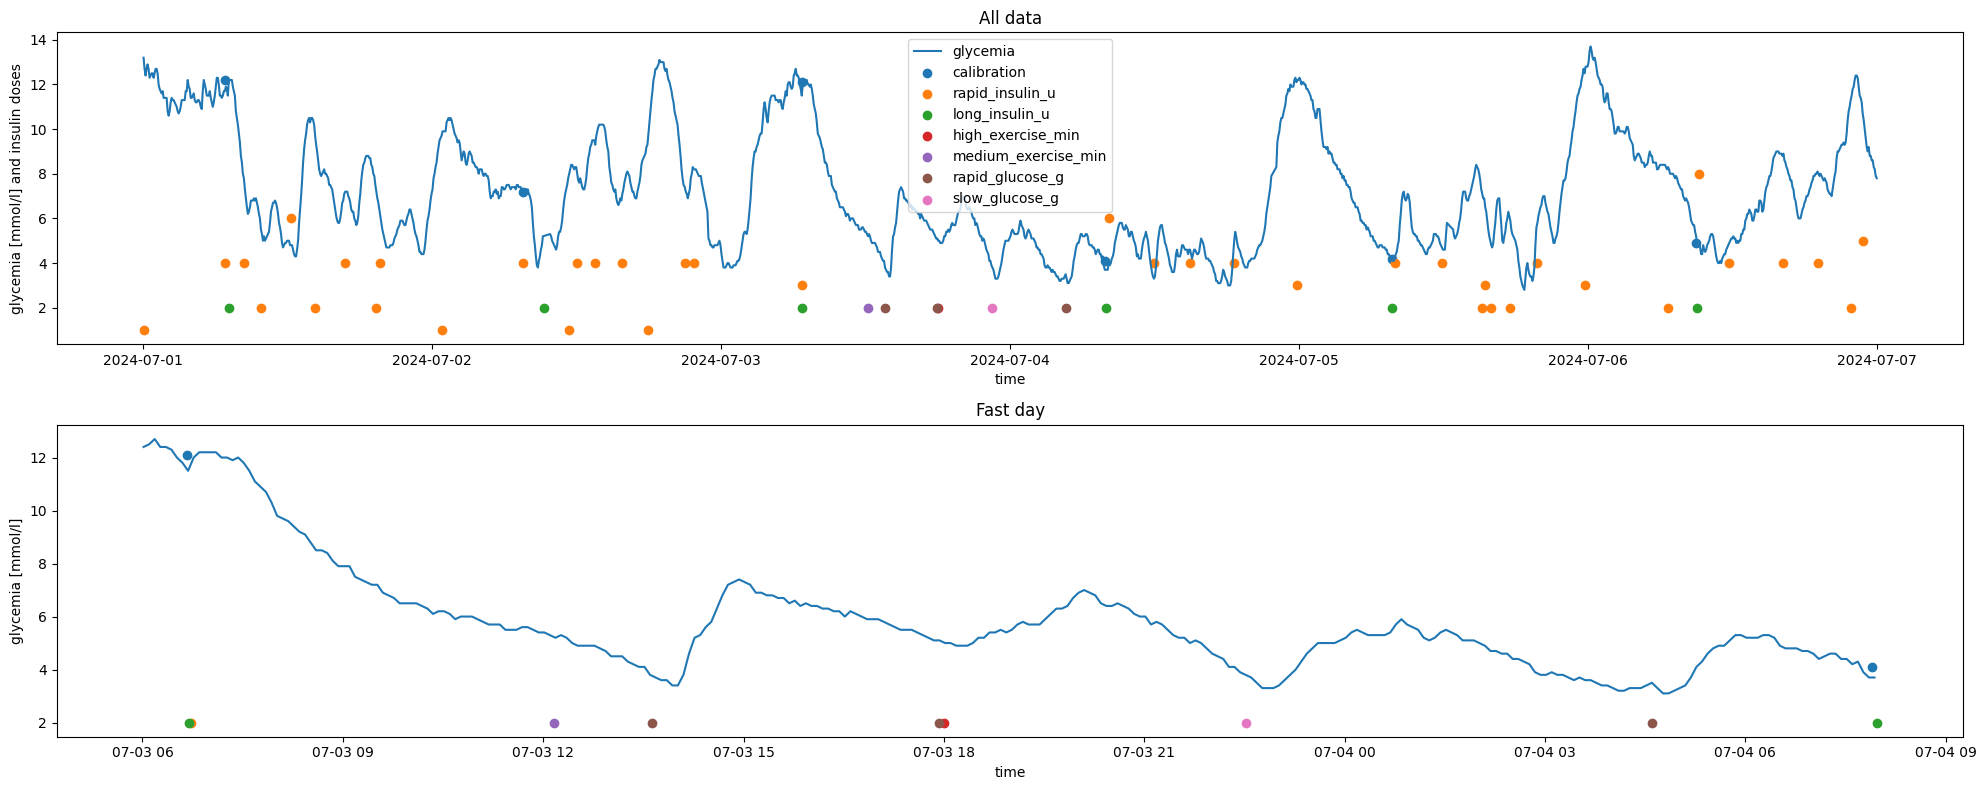

In [9]:
fig, axs = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(20)

data = all_data[all_data['EventType'] == 'glycemia'].copy()
axs[0].plot(data.index,data['Value'], label = 'glycemia')
for type in ['calibration','rapid_insulin_u']:
    data = all_data[all_data['EventType'] == type].copy()
    axs[0].scatter(data.index,data['Value'], label = type)
for type in ['long_insulin_u', 'high_exercise_min', 'medium_exercise_min', 'rapid_glucose_g', 'slow_glucose_g']:
    data = all_data[all_data['EventType'] == type].copy()
    axs[0].scatter(data.index,[2]*len(data), label = type)
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('glycemia [mmol/l] and insulin doses')
axs[0].set_title('All data')

fast_start = datetime(2024,7,3,6)
fast_end = datetime(2024,7,4,8)
data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'glycemia')].copy()
axs[1].plot(data.index,data['Value'])
data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'calibration')].copy()
axs[1].scatter(data.index,data['Value'])
for type in ['rapid_insulin_u','long_insulin_u', 'high_exercise_min', 'medium_exercise_min', 'rapid_glucose_g', 'slow_glucose_g']:
    data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == type)].copy()
    axs[1].scatter(data.index,[2]*len(data))
axs[1].set_xlabel('time')
axs[1].set_ylabel('glycemia [mmol/l]')
axs[1].set_title('Fast day')

fig.tight_layout();

### Calibration

My glycemia measurement system must be calibrated once a day. I incorporate this information into the data below. This section is quite technical and (since there were no calibrations problems during my fast day) no really necessary. If you skip it, keep in mind what the calibrated_glycemia variable is. 

It is not clear to me what happens when the device is calibrated. When there is a difference between the sensor and calibration glycemia, the sensor value is not immediately adjusted. Instead it rapidly (but not instantaneously) moves towards the calibration value over about 3 measurements. I assume that the system works by correcting (by addition or subtraction) the glycemia in small steps over 3 measurements so that by the third measurement the entire correction has been applied.

The calibration should however be applied retroactively for a more precise glycemia value. I do this below. This is done in 3 steps:
- Identify every calibration interval. These are the time intervals between calibrations.
- For each interval, identify the total calibration amplitude. This is the difference between the sensor and finger prick glycemia. It is estimated at the time of calibration. The value of the sensor glycemia is interpolated from the two neighboring values since calibration times never exactly match sensor measurement times.
- Compute the calibration weights. These are numbers that are used to gradually lessen the calibration correction in order to fit the picture above. The corrections are multiplicative. A value of one thus corresponds to no lessening while smaller values decrease the calibration correction. Most measurements are given a number one. Only the first three measurements after each calibration are given different values. The first, second and third sensor measurements have values of $2/3$, $1/3$ and zero respectively.
- Compute the calibration correction within each calibration interval. For each calibration interval, the additive calibration correction is assumed to be a linear function of time, $\text{corr}(t) = a \times t + b$. The parameters $a$ and $b$ are set so that the correction is zero on the third measurement after the previous calibration and matches the total calibration amplitude at the calibration time.
- Apply the calibration correction. Multiply the calibration correction with the calibration weights and add the result to the sensor glycemia.

In [6]:
# Compute a calibration factor. The 3 measurements that come just after a calibration are already adjusted, they will be adjusted with a diminishing amplitude. The glucose correction is multiplied by (2/3,1/3,0).
all_data.loc[all_data['EventType'] == 'glycemia','calibration_factor'] = 1
for cal in all_data[all_data['EventType'] == 'calibration'].index:
    indices = all_data.loc[(all_data['EventType'] == 'glycemia') & (all_data.index >= cal),'calibration_factor'].sort_index().head(3).index
    length = len(indices)
    all_data.loc[all_data.index.isin(indices),'calibration_factor'] = np.arange(2,-length+2,-1)/3

# Here I computed the calibrated glycemia.
zeros = all_data[(all_data['EventType'] == 'glycemia') & (all_data['calibration_factor'] == 0)].index
for ind, z in enumerate(zeros[1:]):
    data = all_data.loc[(all_data['EventType'] == 'glycemia') & (all_data.index <= z) & (all_data.index >= zeros[ind]),['Value','calibration_factor']].copy()
    data = pd.concat([data,pd.DataFrame([[np.nan, np.nan]],index = all_data[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind])].index,columns = data.columns)]).sort_index()
    data['Value'] = data['Value'].interpolate(method = 'time')
    data['elapsed_time'] = (data.index-data.index[0]).total_seconds()
    correction_slope = ((all_data.loc[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind]),'Value'] - data.loc[all_data[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind])].index,'Value'])/(z-zeros[ind]).total_seconds()).values[0]
    data['calibration_correction'] = correction_slope*data['elapsed_time']
    data['calibrated_glycemia'] = data['Value']+data['calibration_factor']*data['calibration_correction']
    all_data.loc[(all_data['EventType'] == 'glycemia') & (all_data.index <= z) & (all_data.index >= zeros[ind]),'calibrated_glycemia'] = data.loc[data.index.isin(all_data[(all_data['EventType'] == 'glycemia') & (all_data.index <= z) & (all_data.index >= zeros[ind])].index),'calibrated_glycemia']

I show the calibrated (in yellow) and uncalibrated (in blue) glycemia below. All the data is shown above and the fast day is shown below. It looks like the calibration correction is working well. In any case, the correction is very small.

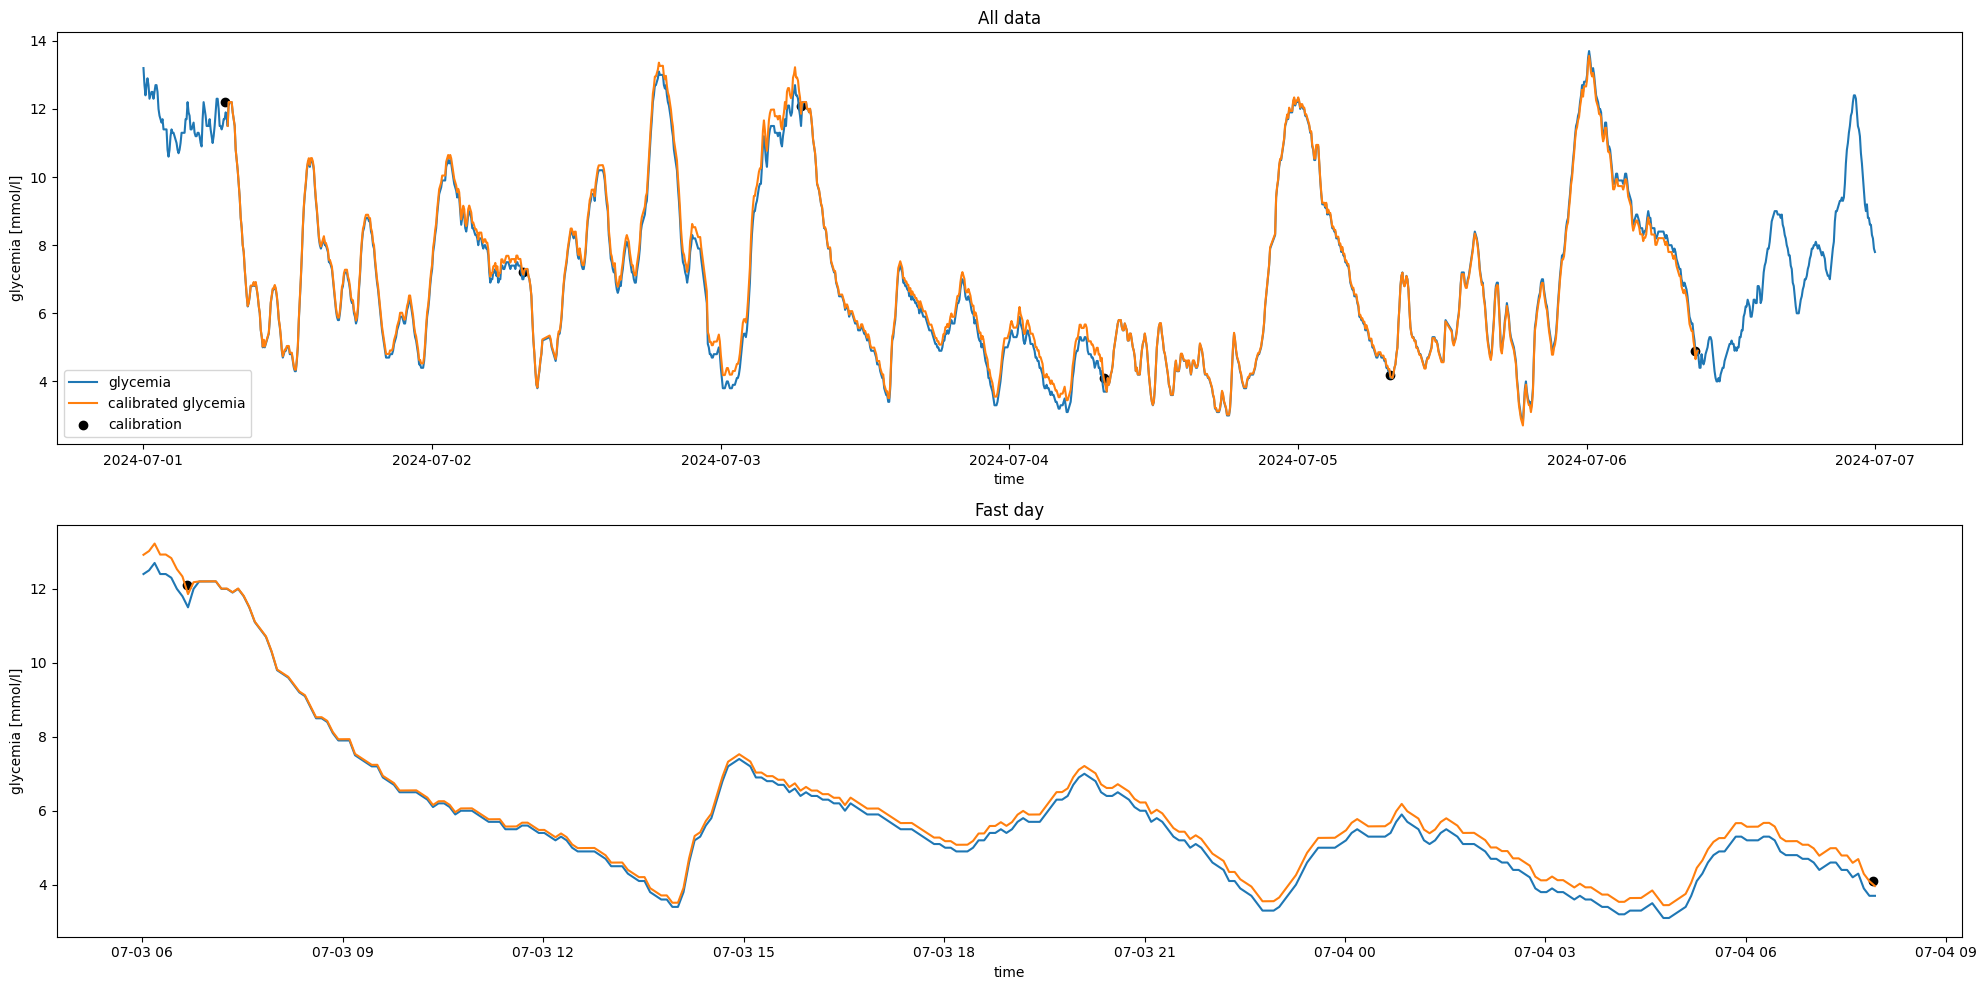

In [10]:
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)

data = all_data[all_data['EventType'] == 'glycemia'].copy()
axs[0].plot(data.index,data['Value'], label = 'glycemia')
axs[0].plot(data.index,data['calibrated_glycemia'], label = 'calibrated glycemia')

data = all_data[all_data['EventType'] == 'calibration'].copy()
axs[0].scatter(data.index,data['Value'], label = 'calibration', color = 'k')

axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('glycemia [mmol/l]')
axs[0].set_title('All data')

data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'glycemia')].copy()
axs[1].plot(data.index,data['Value'], label = 'glycemia')
axs[1].plot(data.index,data['calibrated_glycemia'], label = 'calibrated glucose')

data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'calibration')].copy()
axs[1].scatter(data.index,data['Value'], label = 'calibration', color = 'k')
axs[1].set_title('Fast day')
axs[1].set_xlabel('time')
axs[1].set_ylabel('glycemia [mmol/l]')

fig.tight_layout();

In [11]:
# save the relevant data to a csv file to use later
all_data.loc[(all_data.index < fast_end) & (all_data.index > fast_start),['Value', 'EventType', 'calibrated_glycemia']].copy().to_csv('fast_day.csv')

## 2. Rapid insulin action

In this section I take advantage of the high night-time glycemia at the beginning of the fast period and investigate the ensuing insulin injection. This event provides about 6 hours of glycemia where insulin is acting without any other influences. Below I define the insulin action. This is a measurable quantity that quantifies the effect of insulin over time. This action is assumed to take a simple form with a few interpretable parameters. The goal of this section is to fit the simple form onto my data in order to measure the different parameters. Different values of all the parameters are tried out and the values that lead to the best match between my data and the model prediction are kept and interpreted as measurements.

I model the insulin action with an exponential decay. I assume that the time derivative (the rate of change with time) of the glycemia behaves as

$$ g'(t) = - C - A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-(t-t_0)/\tau} \theta(t-t_0)  \;,$$

with $\theta(t) = \frac{t+|t|}{2 t}$, the heaviside function. It is zero if $t<t_0$ and one otherwise. $t_0$ is the time at which the insulin's effect becomes visible in the sensor. The second term on the right-hand-side can be interpreted as the **insulin action**. When it is zero, the glucose value only drifts. The insulin action term is negative. It can only decrease the glycemia. This model encodes the following phenomena:
- The delayed action of the insulin: Insulin takes some time to diffuse through the body and start to lower the glycemia. Moreover, the glycemia reading from the sensor is also delayed because it actually measures the glucose concentration in the interstitial fluid instead of the blood. This feature is encoded in the $t-t_0$ argument of the exponential and the heaviside function. $t_0$ is the corresponding time delay. In particular the heaviside function $\theta(t)$ ensures that the insulin action is zero as long as $t< t_0$.
- The amplitude of the effect of the shot on the body: More insulin will induce a larger decrease of glycemia. This is encoded in the constant $A$ that I expect is proportional to the injected dose. $A$ has the same physical unit as the glycemia, [mmol/l].
- The decay of the effect of insulin over a few hours: Rapid insulin has an effect on glycemia that rapidly ramps up at first and then stops after a few hours. This is encoded in the $(t-t_0) e^{-(t-t_0)/\tau}$ part. For small (but positive) values of $t-t_0$, this term is small and proportional to $t-t_0$. It grows and hits a maximum at $t-t_0= \tau$ and then decays exponentially. $\tau$ is the time scale of this phenomenon.
- The effect of the long acting insulin: Naturally and without insulin, glucose or exercise, glycemia goes up slowly. I take a shot of slow acting insulin (with a time scale of about 3 days) every morning to keep my glycemia stable. A long acting insulin that is not perfectly dosed will not balance out the slow rise of the glycemia. This will look like a slow drift of the glycemia. This effect is captured by the constant C. If the slow insulin is perfectly dosed, then $C= 0$. If $C<0$ or $C>0$, then more or less long acting insulin is required respectively.

The model ignores the fact that the glycemia can not go below zero. In practice, this is rarely a problem because when it drops too low, I compensate with some sugar. I have however noticed that there seems to be some kind of insulin resistance when $g$ is low. In particular, at times when the glycemia is dropping slowly, it never goes below about 2 [mmol/l] even if I don't eat anything. From the above model (that is valid here because there are no other influences on the glycemia and because the glycemia is quite high), we can infer the time-dependence of the glucose value as

$$g(t) = g_0 - C \, t - \theta(t-t_0) \, \frac{A}{\tau} \, \left[\tau-\text{e}^{-(t-t_0)/\tau} (t-t_0+\tau) \right] \, . $$

$g_0$ is the observed glycemia at the moment of the insulin injection, $t=0$. This model has the following properties:
- $ g(t<t_0) = g_0 - C \,t $. Before the insulin kicks in, the glycemia linearly drifts.
- $g(t = t_0 + \epsilon) \cong g_0 - C \ (t_0 + \epsilon) - \frac{A}{2} \left(\frac{\epsilon}{\tau}\right)^2$, for $\epsilon \ll \tau$. The effect of the insulin kicks in smoothly as $(t-t_0)^2$. It is proportional to $A$.
- $g(t \gg \tau) = g_0 - C \, t - A$. When the insulin effect is finished, the glycemia returns to a slow drift with a value that is decreased by $A$. The insulin injection has decreased the glycemia by $A$.

In this section, I will fit the above model to my data and extract numerical values for $g_0$, $C$, $t_0$, $A$ and $\tau$.

Below, I extract the relevant data and prepare some functions to be used later. The first five rows of data are displayed.

In [1]:
# Get the data and extract the relevant part.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

data = pd.read_csv('fast_day.csv').set_index('Unnamed: 0')
data.index = pd.to_datetime(data.index)
data.index.name = 'time'
# The insulin is acting alone immediately after my first (and only in this dataset) injection and right before I went to collect my daughter at kindergarden.
# Include the two injection and exercise events in the data set with interpolated glycemia values.
data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glycemia']],index = data[data['EventType'] == 'rapid_insulin_u'].index, columns = ['Value','calibrated_glycemia','EventType']),data]).sort_index()
data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glycemia']],index = data[data['EventType'] == 'medium_exercise_min'].index, columns = ['Value','calibrated_glycemia','EventType']),data]).sort_index()
data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']] = data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']].interpolate(method = 'time')
data = data.loc[(data['EventType'] == 'glycemia') & (data.index >= data[data['EventType'] == 'rapid_insulin_u'].index[0]) & (data.index <= data[data['EventType'] == 'medium_exercise_min'].index[0]),['Value','calibrated_glycemia']]
data['elapsed_time_h'] = (data.index-data.index[0]).total_seconds()/3600
display(data.head(5))

def theta(x):
    # I use a smooth version of the heaviside function to avoid tripping the fit algorithm.
    scale = 0.01
    return (np.tanh(x/scale)+1)/2

def tofit(t,C, g0,t0,A,tau):
    # This is the model described above.
    return g0-C*t+theta(t-t0)*(A/tau)*(
        (tau+t-t0)*np.exp(-(t-t0)/tau)-tau
        )

def insulin_action(t,C, g0,t0,A,tau):
    # This is the insulin action. I multiply it by tau so that is has the same units as the glycemia [mmol/l]. I also adjust the sign to make it positive.
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)/tau)/(tau**2)

def to_zero(x, epsilon = 0.2):
    # finding x so that this returns zero provides the time when the glycemia level has decreased by 1-epsilon.
    return (1+x)*np.exp(-x)-epsilon

,Value,calibrated_glycemia,elapsed_time_h
time,,,
2024-07-03 06:44:00,11.8,12.05057,0.000000
2024-07-03 06:46:00,12.0,12.17935,0.033333
2024-07-03 06:51:00,12.2,12.20000,0.116667
2024-07-03 06:56:00,12.2,12.20132,0.200000
2024-07-03 07:01:00,12.2,12.20264,0.283333


Below, I fit the model described above to the data. I show a figure and a table. The figure contains

- the measured glycemia (blue dots)
- the fitted glycemia (blue line)
- the evolution of the glycemia predicted by the model without insulin (i.e. just the drift term) (orange line)
- the scaled insulin action (green line).

The table summarises useful statistics and measurements extracted from the model:

- mae: The mean average error is a standard estimation of model quality. It is the mean of the absolute value of the differences between the measured and predicted data. Is is given in [mmol/l] and can be directly interpreted as the typical size of the error that the model makes.
- rmse: The root mean squared error is another estimator of model quality. It is the square root of the mean of the squares of the differences between the measured and predicted data. Is is als given in [mmol/l] and can be directly interpreted and the typical size of the error that the model makes.
- Slow drift [mmol/(lh)]: The drift parameter C in the model.
- Action delay [minutes]: The delay parameter $t_0$ in the model.
- Action time scale [minutes]: The time scale parameter $\tau$ in the parameter.
- Total glycemia decrease [mmol/l]: The change in glycemia that is a result of the insulin shot (without the drift). This is the parameter $A$ in the model.
- Time to 20% [hours]: The time to wait since the injection for the glycemia to decrease by 20% of its total decrease. This provides an estimation of the onset time of the insulin action.
- Time to 80% [hours]: The time to wait since the injection for the glycemia to decrease by 80% of its total decrease. This provides an estimation of the total time of the insulin action.

,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia decrease [mmol/l],Time to 20% [hours],Time to 80% [hours]
Event start,,,,,,,,
2024-07-03 06:44:00,0.077,0.104,0.375,28.524,41.236,4.859,1.042,2.533


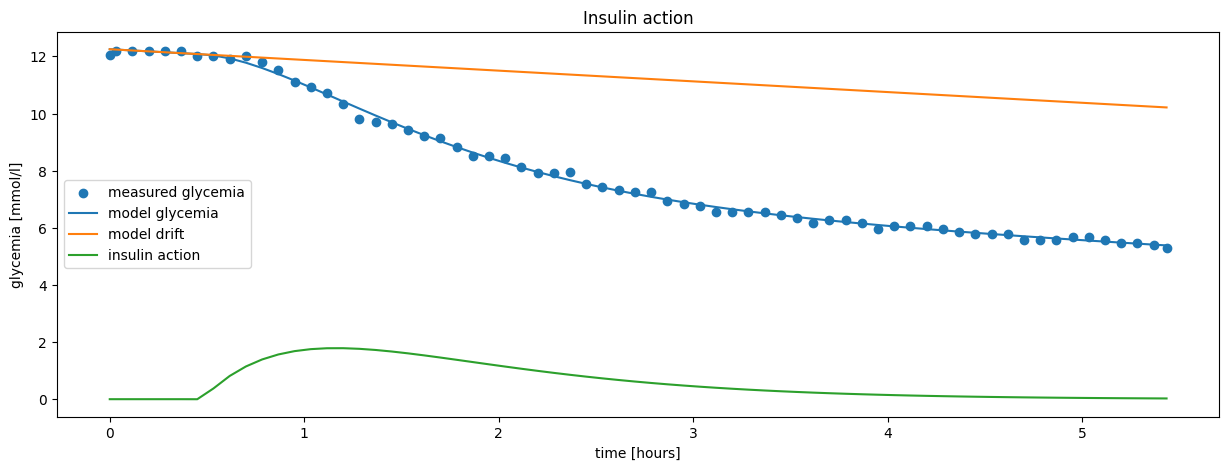

In [4]:
# fit the data
popt, _ = curve_fit(tofit, data['elapsed_time_h'],data['calibrated_glycemia'], p0 = [0, 12,0.75,11.5,0.6])
# the times to 20% and 80% can not be computed exactly. Use a numerical approximation
time_solution = fsolve(to_zero, 1)
time_solution_first_effect = fsolve(lambda x: to_zero(x,0.8), 1)

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glycemia'], label = 'measured glycemia')
axs.plot(data['elapsed_time_h'],tofit(data['elapsed_time_h'], *popt), label = 'model glycemia')
axs.plot(data['elapsed_time_h'],popt[1]- popt[0]*data['elapsed_time_h'], label = 'model drift')
axs.plot(data['elapsed_time_h'],insulin_action(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.set_xlabel('time [hours]')
axs.set_ylabel('glycemia [mmol/l]')
axs.set_title('Insulin action')
axs.legend();

columns = ['mae [mmol/l]','rmse [mmol/l]', 'Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia decrease [mmol/l]','Time to 20% [hours]','Time to 80% [hours]']
values = ([np.abs(data['calibrated_glycemia']-tofit(data['elapsed_time_h'], *popt)).mean(),
(((data['calibrated_glycemia']-tofit(data['elapsed_time_h'], *popt))**2).mean()**0.5), data.index[0],
popt[0], popt[2]*60, popt[4]*60, popt[3],popt[2]+popt[4]*time_solution_first_effect[0], popt[2]+popt[4]*time_solution[0]])
pd.DataFrame([values],columns = columns, index = ['']).set_index('Event start').to_csv('insulin_action_1.csv')
round(pd.DataFrame([values],columns = columns, index = ['']).set_index('Event start'),3)

The model looks like it's working well. The errors are small and more or less randomly distributed around the fit. The drift matches the data until the delay time and the decrease in glycemia returns to a drift with the same parameter after the insulin action has ended. The insulin action ends within the window of observed data.

Before moving on to interpreting these results, I try an alternative model. This will increase our confidence in the results. This model is very similar to the first one, but the simple form of the insulin action is a bit different,

$$ g'(t) = - C - A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-1/2[(t-t_0)/\tau]^2} \theta(t-t_0)  \;.$$

It works in the same way as the model described above. I make the same analysis below.

,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia decrease [mmol/l],Time to 20% [hours],Time to 80% [hours]
Event start,,,,,,,,
2024-07-03 06:44:00,0.093,0.13,0.527,16.104,66.264,4.131,1.006,2.25


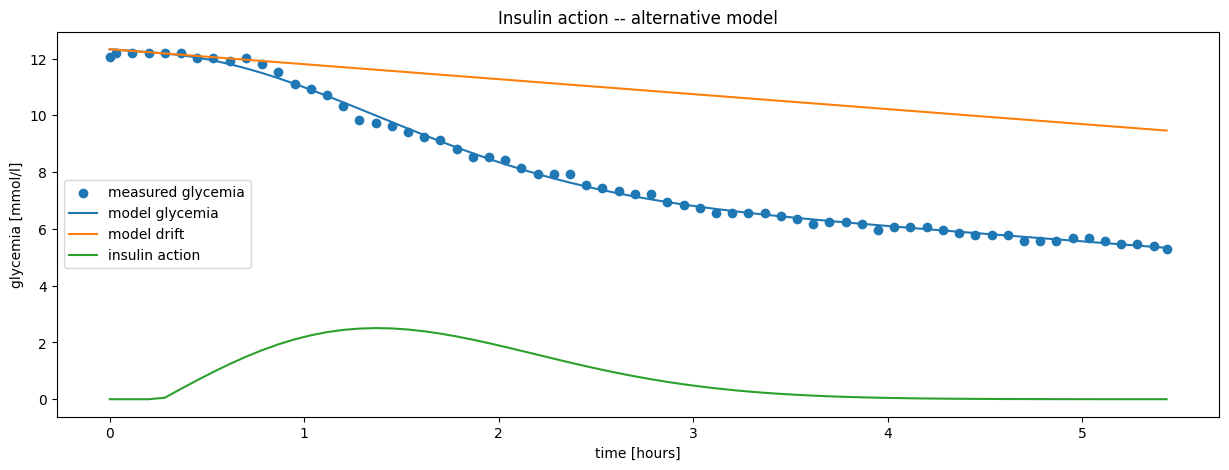

In [5]:
def tofit_square(t,C, g0,t0,A,tau):
    # This is the alternative model.
    return g0-C*t-theta(t-t0)*A*(1-np.exp(-0.5*(t-t0)**2/tau**2))

def insulin_action_square(t,C, g0,t0,A,tau):
    # This is the corresponding insulin action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-0.5*(t-t0)**2/tau**2)/(tau**2)

# fit the data
popt, _ = curve_fit(tofit_square, data['elapsed_time_h'],data['calibrated_glycemia'], p0 = [0, 12,0.75,11.5,0.6])
# This time there is an exact solution for the times to 20% and 80%.
time_solution = [(-2*np.log(0.2))**0.5]
time_solution_first_effect = [(-2*np.log(0.8))**0.5]

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glycemia'], label = 'measured glycemia')
axs.plot(data['elapsed_time_h'],tofit_square(data['elapsed_time_h'], *popt), label = 'model glycemia')
axs.plot(data['elapsed_time_h'],popt[1]- popt[0]*data['elapsed_time_h'], label = 'model drift')
axs.plot(data['elapsed_time_h'],insulin_action_square(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.set_xlabel('time [hours]')
axs.set_ylabel('glycemia [mmol/l]')
axs.set_title('Insulin action -- alternative model')
axs.legend();

columns = ['mae [mmol/l]','rmse [mmol/l]', 'Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia decrease [mmol/l]', 'Time to 20% [hours]', 'Time to 80% [hours]']
values = ([np.abs(data['calibrated_glycemia']-tofit_square(data['elapsed_time_h'], *popt)).mean(),
(((data['calibrated_glycemia']-tofit_square(data['elapsed_time_h'], *popt))**2).mean()**0.5), data.index[0],
popt[0], popt[2]*60, popt[4]*60, popt[3],popt[2]+popt[4]*time_solution_first_effect[0],popt[2]+popt[4]*time_solution[0]])
pd.DataFrame([values],columns = columns, index = ['']).set_index('Event start').to_csv('insulin_action_2.csv')
round(pd.DataFrame([values],columns = columns, index = ['']).set_index('Event start'),3)

Comparing the two models (The model statistics are repeated below.), I slightly prefer the first one because:

- Both (mae and mse) scores are better.
- The action delay time fits better with what I was taught.

In [6]:
temp = pd.concat([pd.read_csv('insulin_action_1.csv'),pd.read_csv('insulin_action_2.csv')])
temp.index = ['model 1','model 2']
temp = temp.drop(columns = ['Event start'])
round(temp,3)

,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia decrease [mmol/l],Time to 20% [hours],Time to 80% [hours]
model 1,0.077,0.104,0.375,28.524,41.236,4.859,1.042,2.533
model 2,0.093,0.130,0.527,16.104,66.264,4.131,1.006,2.250


In any case, the two models provide more or less compatible result. The only real difference is the insulin action delay measurement: about 29 (first model) and 16 (second model) minutes. The action time scales also differ significantly, but these are model parameters that are not directly observable. They do not need to match exactly. The total glycemia decreases and the times to reach 20% and 80% of the total decrease more or less match.

I see from this analysis that my long acting insulin is a bit overdosed. I could lessen the drift term by injecting a little less of it. I will also keep in mind the time scale of 2.5 hours for the action of the rapid insulin.

## 3. Food action curve

In this section, I repeat the above analysis, but with my glucose intakes instead of insulin action. During the fast day, I ate carbohydrates 4 times. 3 of them were white sugar (fast acting) and one was dark chocolate (slow acting). All these events were in the second half of the day and can be assumed to be independent of the rapid acting insulin injection. One of the rapid sugar intakes corresponds to a high intensity exercise event and will be discarded. The other 3 events are assumed to be independent from insulin and exercise. The model is essentially the same as before

$$ g'(t) = - C + A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-(t-t_0)/\tau} \theta(t-t_0)  \;,$$

with the difference that the glycemia goes up (the sign of $A$ is flipped). $t_0$ only reflects the delay in the sensor measurement and is expected to be smaller this time.

In [1]:
# Get the data and extract the relevant part.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime

data = pd.read_csv('fast_day.csv').set_index('Unnamed: 0')
data.index = pd.to_datetime(data.index)
data.index.name = 'time'
data = data.sort_index()

# Make an array with the three carbohydrate intake events. Each element of the array is a DataFrame.
carb_events_start = [data[data['EventType'] == 'rapid_glucose_g'].index[0], data[data['EventType'] == 'slow_glucose_g'].index[0], data[data['EventType'] == 'rapid_glucose_g'].index[-1]]
events = []
for ev in carb_events_start:
    ev_end = data[(data['EventType'] != 'glycemia') & (data['EventType'] != 'calibration') & (data.index >= ev)].iloc[1].name
    data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glycemia']],index = [ev,ev_end], columns = ['Value','calibrated_glycemia','EventType']),data]).sort_index()
    data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']] = data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']].interpolate(method = 'time')

    temp = data.loc[(data.index <= ev_end) & (data.index >= ev) & (data['EventType'] == 'glycemia'),['Value','calibrated_glycemia']].sort_index()
    temp['elapsed_time_h'] = (temp.index-temp.index[0]).total_seconds()/(3600)
    temp = temp[temp['elapsed_time_h']<4]
    temp.index.name = ev
    events.append(temp)

for ev, type in zip(events,['rapid_glucose_g','slow_glucose_g','rapid_glucose_g']):
    ev.columns.name = type

def theta(x):
    # I use a smooth version of the heaviside function to avoid tripping the fit algorithm.
    scale = 0.01
    return (np.tanh(x/scale)+1)/2

def tofit(t,C, g0,t0,A,tau):
    # This is the model described above.
    return g0-C*t-theta(t-t0)*(A/tau)*(
        (tau+t-t0)*np.exp(-(t-t0)/tau)-tau
        )

def glucose_action(t,C, g0,t0,A,tau):
    # This is the glucose action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)/tau)/(tau**2)

def tofit_square(t,C, g0,t0,A,tau):
    # This is the alternative model.
    return g0-C*t+theta(t-t0)*A*(1-np.exp(-0.5*(t-t0)**2/tau**2))

def glucose_action_square(t,C, g0,t0,A,tau):
    # This is the corresponding glucose action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-0.5*(t-t0)**2/tau**2)/(tau**2)

def to_zero(x, epsilon = 0.2):
    # finding x so that this returns zero provides the time when the glycemia level has increased by 1-epsilon.
    return (1+x)*np.exp(-x)-epsilon

As before, I fit the model and provide figures and a table. The details of the figures and content or the table are the same as above. See the previous section for a detailed description of the different fields. This time, there is one figure for each event and all three events are grouped in a single table.

I start with the first model (with the $\text{e}^{-(t-t_0)/\tau}$ term).

,EventType,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia increase [mmol/l],Time to 20% [hours],Time to 80% [hours]
Event start,,,,,,,,,
2024-07-03 13:38:00,rapid_glucose_g,0.121,0.165,0.698,21.222,12.841,4.492,0.530,0.995
2024-07-03 22:31:00,slow_glucose_g,0.134,0.156,0.727,16.882,29.792,3.944,0.691,1.768
2024-07-04 04:36:00,rapid_glucose_g,0.100,0.121,0.959,17.596,18.010,3.607,0.541,1.192


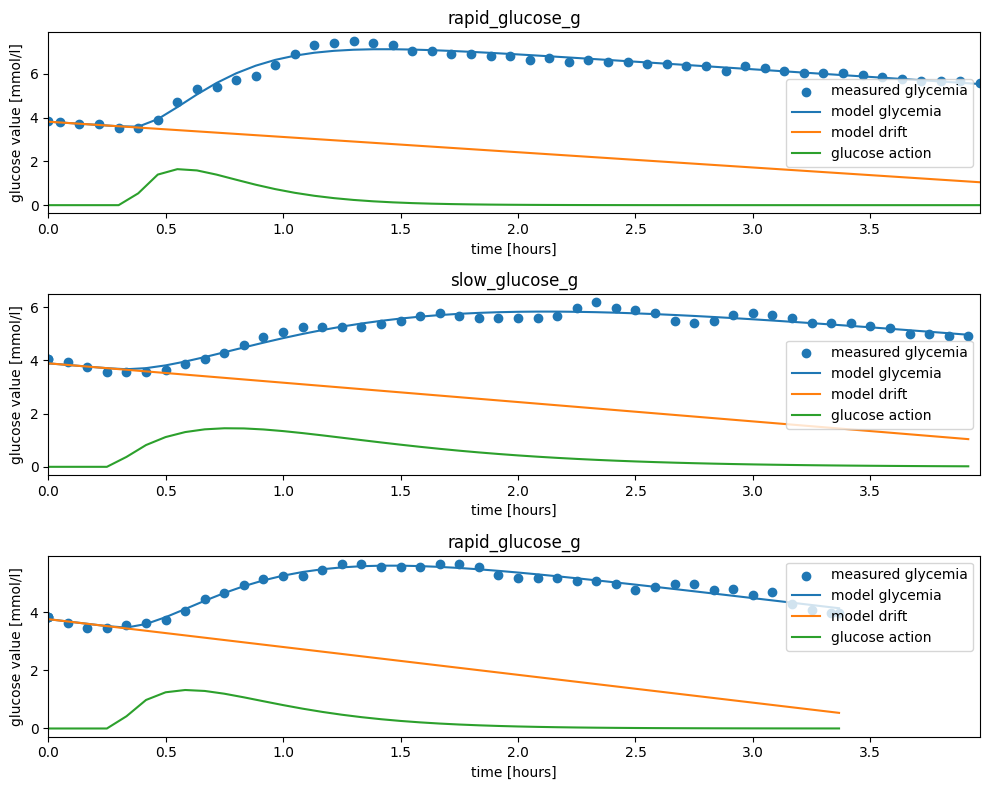

In [2]:
fig, axs = plt.subplots(3)
fig.set_figheight(8)
fig.set_figwidth(10)

# I scale the horizontal axes of all the figures in the same way. That way the time scales can be compared visually.
max_time = 0
for ev in events:
    max_time = max(max_time,ev['elapsed_time_h'].max())

events_description = pd.DataFrame(['rapid_glucose_g','slow_glucose_g','rapid_glucose_g'],index = [0,1,2],columns = ['EventType'])

for ind, ev in enumerate(events):

    popt, _ = curve_fit(tofit, ev['elapsed_time_h'],ev['calibrated_glycemia'], p0 = [0, 3,0.75,4,0.6])
    time_solution = fsolve(to_zero, 1)
    time_solution_first_effect = fsolve(lambda x: to_zero(x,0.8), 1)

    axs[ind].scatter(ev['elapsed_time_h'],ev['calibrated_glycemia'], label = 'measured glycemia')
    axs[ind].plot(ev['elapsed_time_h'],tofit(ev['elapsed_time_h'], *popt), label = 'model glycemia')
    axs[ind].plot(ev['elapsed_time_h'],popt[1]-popt[0]*ev['elapsed_time_h'], label = 'model drift')
    axs[ind].plot(ev['elapsed_time_h'],glucose_action(ev['elapsed_time_h'], *popt), label = 'glucose action')
    axs[ind].set_title(ev.columns.name)
    axs[ind].set_xlim([0,max_time])
    axs[ind].legend()
    axs[ind].set_xlabel('time [hours]')
    axs[ind].set_ylabel('glucose value [mmol/l]')

    columns = ['mae [mmol/l]','rmse [mmol/l]','Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia increase [mmol/l]','Time to 20% [hours]', 'Time to 80% [hours]']
    values = ([np.abs(ev['calibrated_glycemia']-tofit(ev['elapsed_time_h'], *popt)).mean(),
    (((ev['calibrated_glycemia']-tofit(ev['elapsed_time_h'], *popt))**2).mean()**0.5),
    ev.index[0],
    popt[0],
    popt[2]*60,
    popt[4]*60,
    popt[3],popt[2]+popt[4]*time_solution_first_effect[0],
    popt[2]+popt[4]*time_solution[0]])
    events_description.loc[ind,columns] = values
fig.tight_layout();
events_description = events_description.set_index('Event start')
events_description.to_csv('glucose_action_1.csv')
round(events_description,3)

Below, I show the same results, but with the second model, with $\text{e}^{-0.5(t-t_0)²/\tau^2}$.

,EventType,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia increase [mmol/l],Time to 20% [hours],Time to 80% [hours]
Event start,,,,,,,,,
2024-07-03 13:38:00,rapid_glucose_g,0.110,0.150,0.666,15.864,23.679,4.403,0.528,0.972
2024-07-03 22:31:00,slow_glucose_g,0.157,0.180,0.515,9.813,45.480,3.211,0.670,1.524
2024-07-04 04:36:00,rapid_glucose_g,0.106,0.127,0.847,11.822,30.152,3.302,0.533,1.099


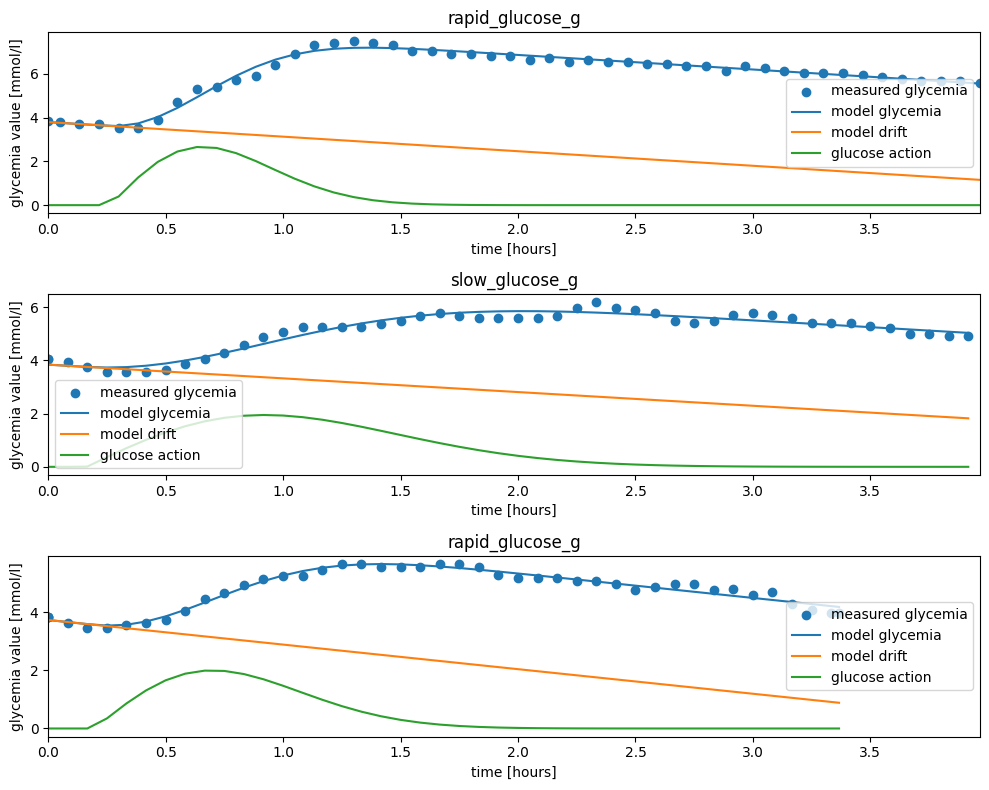

In [3]:
fig, axs = plt.subplots(3)
fig.set_figheight(8)
fig.set_figwidth(10)

max_time = 0
for ev in events:
    max_time = max(max_time,ev['elapsed_time_h'].max())

events_description = pd.DataFrame(['rapid_glucose_g','slow_glucose_g','rapid_glucose_g'],index = [0,1,2],columns = ['EventType'])

for ind, ev in enumerate(events):

    popt, _ = curve_fit(tofit_square, ev['elapsed_time_h'],ev['calibrated_glycemia'], p0 = [0, 3,0.75,4,0.6])
    time_solution = [(-2*np.log(0.2))**0.5]
    time_solution_first_effect = [(-2*np.log(0.8))**0.5]

    axs[ind].scatter(ev['elapsed_time_h'],ev['calibrated_glycemia'], label = 'measured glycemia')
    axs[ind].plot(ev['elapsed_time_h'],tofit_square(ev['elapsed_time_h'], *popt), label = 'model glycemia')
    axs[ind].plot(ev['elapsed_time_h'],popt[1]-popt[0]*ev['elapsed_time_h'], label = 'model drift')
    axs[ind].plot(ev['elapsed_time_h'],glucose_action_square(ev['elapsed_time_h'], *popt), label = 'glucose action')
    axs[ind].set_title(ev.columns.name)
    axs[ind].set_xlim([0,max_time])
    axs[ind].legend()
    axs[ind].set_xlabel('time [hours]')
    axs[ind].set_ylabel('glycemia value [mmol/l]')

    columns = ['mae [mmol/l]','rmse [mmol/l]','Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]','Action time scale [minutes]',
               'Total glycemia increase [mmol/l]','Time to 20% [hours]', 'Time to 80% [hours]']
    values = ([np.abs(ev['calibrated_glycemia']-tofit_square(ev['elapsed_time_h'], *popt)).mean(),
    (((ev['calibrated_glycemia']-tofit_square(ev['elapsed_time_h'], *popt))**2).mean()**0.5),
    ev.index[0],
    popt[0],
    popt[2]*60,
    popt[4]*60,
    popt[3],popt[2]+popt[4]*time_solution_first_effect[0],popt[2]+popt[4]*time_solution[0]])
    events_description.loc[ind,columns] = values
fig.tight_layout();
events_description = events_description.set_index('Event start')
events_description.to_csv('glucose_action_2.csv')
round(events_description,3)

As before the two models look like they are working well. See the table below. All the scores are small and the drift captures the data before and after eating glucose. The second model has better score for rapid sugar and a worse score for slow glucose. This is ok. These are two different foods (white sugar and brown chocolate), which surely have different actions in time. The two models provide more or less the same results, except for:
- Action delay [minutes]: As for the insulin model, the action delay is evaluated to be much shorter with the second model.
- Action time scale [minutes]: The action time scale is about twice larger for the second model. This is no problem since this quantity is not directly observable. It is a hidden model parameter.

In [6]:
temp = pd.concat([pd.read_csv('glucose_action_1.csv'),pd.read_csv('glucose_action_2.csv')])
temp.index = ['model 1','model 1','model 1', 'model 2','model 2','model 2']
temp.sort_values('Event start')

,Event start,EventType,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia increase [mmol/l],Time to 20% [hours],Time to 80% [hours]
model 1,2024-07-03 13:38:00,rapid_glucose_g,0.120599,0.165485,0.698294,21.222410,12.840535,4.491594,0.530133,0.994516
model 2,2024-07-03 13:38:00,rapid_glucose_g,0.109560,0.149703,0.665945,15.863791,23.679345,4.403444,0.528045,0.972457
model 1,2024-07-03 22:31:00,slow_glucose_g,0.134046,0.156323,0.727388,16.881535,29.791705,3.944012,0.690691,1.768118
model 2,2024-07-03 22:31:00,slow_glucose_g,0.156731,0.180280,0.514868,9.813176,45.480498,3.211052,0.669938,1.523513
model 1,2024-07-04 04:36:00,rapid_glucose_g,0.100441,0.121200,0.959207,17.596181,18.010215,3.607139,0.540727,1.192072
model 2,2024-07-04 04:36:00,rapid_glucose_g,0.105564,0.127019,0.847169,11.822435,30.152009,3.302075,0.532757,1.098647


These discrepancies can in principle be resolved by incrementally improving the two models until the models and the numerical results match. Then, the best of the two models is the one that provides results that are closer to these. The rationale behind this is that one of the two above models is probably closest to the maximally improved model. We should pick that one. In practice, this is difficult to do because I only have a limited amount of data at hand. I can not add many more parameters to the model. I implemented this in a minimal way by combining the two models. I use the following glucose action:

$$ g'(t) = - C + \frac{A}{2} \, \theta(t-t_0) \left(\frac{t-t_0}{\tau_1^2} \, \text{e}^{-(t-t_0)/\tau_1}   + \frac{t-t_0}{\tau_2^2} \, \text{e}^{-1/2[(t-t_0)/\tau_2]^2} \right) \;.$$

This model can fit the data slightly better because it contains one more parameter. The results below (with this improved model) seem to indicate that the longer action delay values are more trustworthy.

,EventType,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale 1 [minutes],Action time scale 2 [minutes],Total glycemia increase [mmol/l]
Event start,,,,,,,,
2024-07-03 13:38:00,rapid_glucose_g,0.111,0.151,0.673,20.226,10.567,24.141,4.418
2024-07-03 22:31:00,slow_glucose_g,0.135,0.160,0.782,16.931,53.487,30.926,4.384
2024-07-04 04:36:00,rapid_glucose_g,0.102,0.123,0.891,18.904,11.584,33.305,3.403


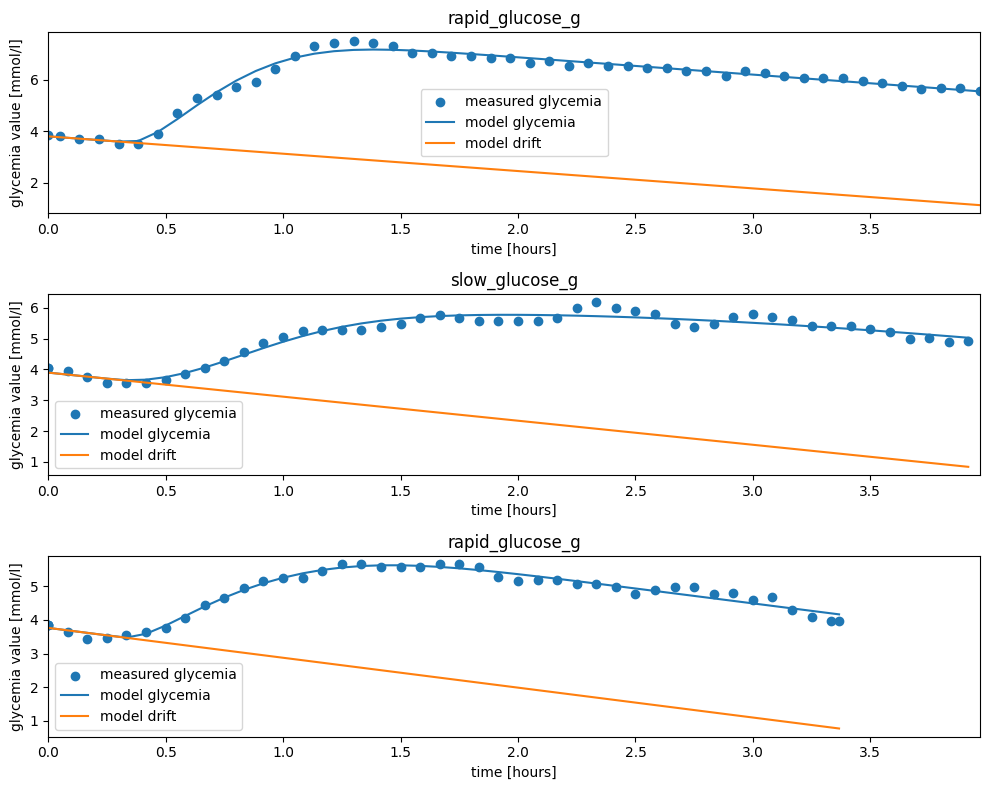

In [4]:
def tofit_two_models(t,C, g0,t0,A,tau1,tau2):

    return g0-C*t+tofit(t,0, 0,t0,A/2,tau1)+tofit_square(t,0, 0,t0,A/2,tau2)

fig, axs = plt.subplots(3)
fig.set_figheight(8)
fig.set_figwidth(10)

events_description = pd.DataFrame(['rapid_glucose_g','slow_glucose_g','rapid_glucose_g'],index = [0,1,2],columns = ['EventType'])

for ind, ev in enumerate(events):
    popt, _ = curve_fit(tofit_two_models, ev['elapsed_time_h'],ev['calibrated_glycemia'], p0 = [0.5, 4,0.25,2,1,1])
    
    axs[ind].scatter(ev['elapsed_time_h'],ev['calibrated_glycemia'], label = 'measured glycemia')
    axs[ind].plot(ev['elapsed_time_h'],tofit_two_models(ev['elapsed_time_h'], *popt), label = 'model glycemia')
    axs[ind].plot(ev['elapsed_time_h'],popt[1]-popt[0]*ev['elapsed_time_h'], label = 'model drift')
    axs[ind].set_title(ev.columns.name)
    axs[ind].set_xlim([0,max_time])
    axs[ind].legend()
    axs[ind].set_xlabel('time [hours]')
    axs[ind].set_ylabel('glycemia value [mmol/l]')

    columns = ['mae [mmol/l]','rmse [mmol/l]','Event start', 'Slow drift [mmol/(lh)]','Action delay [minutes]',
               'Action time scale 1 [minutes]', 'Action time scale 2 [minutes]',
               'Total glycemia increase [mmol/l]']
    values = ([np.abs(ev['calibrated_glycemia']-tofit_two_models(ev['elapsed_time_h'], *popt)).mean(),
    (((ev['calibrated_glycemia']-tofit_two_models(ev['elapsed_time_h'], *popt))**2).mean()**0.5),
    ev.index[0],
    popt[0],
    popt[2]*60,
    popt[4]*60,
    popt[5]*60,
    popt[3]])
    events_description.loc[ind,columns] = values
fig.tight_layout();
events_description = events_description.set_index('Event start')
events_description.to_csv('glucose_action_3.csv')
round(events_description,3)

Apart from the action delay, the two model provide quite consistent results. In particular:

- For both models, the action time scale is about twice as long for the slow glucose.
- The total glycemia increase and time to reach 20% and 80% are consistent between the two models.
- As expected, the total glycemia increase is about the same for the 3 events.
- The time to reach 80% is about 1.5 time longer for the slow carbs.

In [5]:
temp = pd.concat([pd.read_csv('glucose_action_1.csv'),pd.read_csv('glucose_action_2.csv')])
temp.index = ['model 1','model 1','model 1', 'model 2','model 2','model 2']
round(temp.sort_values('Event start'),1)

,Event start,EventType,mae [mmol/l],rmse [mmol/l],Slow drift [mmol/(lh)],Action delay [minutes],Action time scale [minutes],Total glycemia increase [mmol/l],Time to 20% [hours],Time to 80% [hours]
model 1,2024-07-03 13:38:00,rapid_glucose_g,0.1,0.2,0.7,21.2,12.8,4.5,0.5,1.0
model 2,2024-07-03 13:38:00,rapid_glucose_g,0.1,0.1,0.7,15.9,23.7,4.4,0.5,1.0
model 1,2024-07-03 22:31:00,slow_glucose_g,0.1,0.2,0.7,16.9,29.8,3.9,0.7,1.8
model 2,2024-07-03 22:31:00,slow_glucose_g,0.2,0.2,0.5,9.8,45.5,3.2,0.7,1.5
model 1,2024-07-04 04:36:00,rapid_glucose_g,0.1,0.1,1.0,17.6,18.0,3.6,0.5,1.2
model 2,2024-07-04 04:36:00,rapid_glucose_g,0.1,0.1,0.8,11.8,30.2,3.3,0.5,1.1


## 4. Effect of exercise

In this section, I look at the effect of exercise on my glycemia. I only have a single event (at 12h10) when I exercised without eating and when no rapid insulin is working. Here I use a very simple model. I will not attempt to model the details because exercise can be very complex. Indeed, it can widely vary in duration, intensity and kind. I assume that exercise only boosts the effect of insulin. More specifically, I do not model the glycemia during the effort. Instead I measure the slow drift of the glycemia before and after the effort.

In [1]:
# Get the data and extract the relevant part.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

data = pd.read_csv('fast_day.csv').set_index('Unnamed: 0')
data.index = pd.to_datetime(data.index)
data.index.name = 'time'
data = data.sort_index()

# Identify the exercise event.
exercise_duration_min = data.loc[data['EventType'] == 'medium_exercise_min','Value'].values[0]
exercise_event_start = data[data['EventType'] == 'medium_exercise_min'].index[0]
exercise_event_end = data[(data['EventType'] != 'glycemia') & (data['EventType'] != 'calibration') & (data.index >= exercise_event_start)].iloc[1].name
data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glycemia']],index = [exercise_event_start,exercise_event_end], columns = ['Value','calibrated_glycemia','EventType']),data]).sort_index()
data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']] = data.loc[data['EventType'] == 'glycemia',['Value','calibrated_glycemia']].interpolate(method = 'time')
data = data.loc[(data.index <= exercise_event_end) & (data.index >= exercise_event_start-timedelta(hours = 1)) & (data['EventType'] == 'glycemia'),['Value','calibrated_glycemia']].sort_index()
data['elapsed_time_h'] = (data.index-data.index[0]).total_seconds()/(3600)
data['exercise_ongoing'] = (data.index > exercise_event_start) & (data.index <=exercise_event_start+timedelta(minutes = exercise_duration_min))

The figure below shows the glycemia as a function of time. The glycemia during the effort is shown in red and the rest is in blue. I fit the glycemia before and after the effort independently. I use a very simple form

$$ g(t) = g_0 - C t \, ,$$

that captures only the slow drift. The two fit predictions (before and after the effort) are shown as green and black lines respectively. The two different slow drift values are shown in a table and in the legend of the figure as the slope of the lines.

,Slow drift [mmol/(lh)],drift start,drift end
before exercise,0.353,2024-07-03 11:11:00,2024-07-03 12:06:00
after exercise,1.224,2024-07-03 12:51:00,2024-07-03 13:38:00


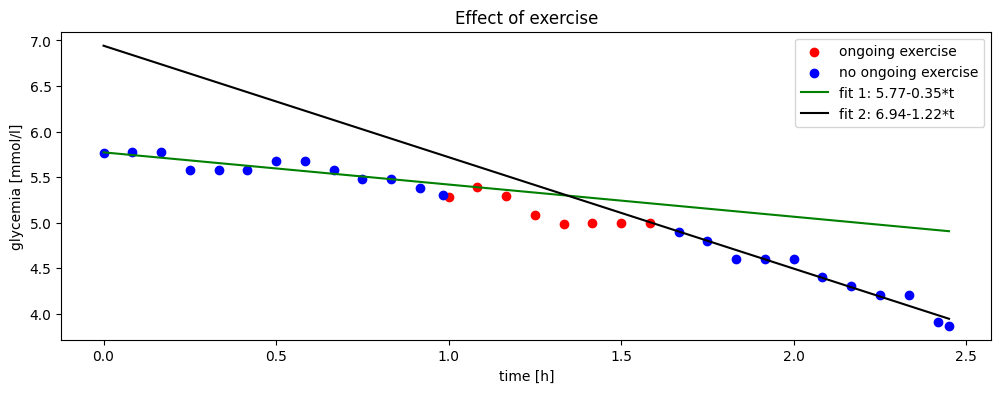

In [2]:
fig, axs = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(12)

axs.scatter(data.loc[data['exercise_ongoing'],'elapsed_time_h'],data.loc[data['exercise_ongoing'],'calibrated_glycemia'], color = 'red', label = 'ongoing exercise')
axs.scatter(data.loc[~data['exercise_ongoing'],'elapsed_time_h'],data.loc[~data['exercise_ongoing'],'calibrated_glycemia'], color = 'blue', label = 'no ongoing exercise')

p = np.polyfit(data.loc[data.index<exercise_event_start,'elapsed_time_h'],data.loc[data.index<exercise_event_start,'calibrated_glycemia'],1)
drifts = pd.DataFrame([[-p[0], data.loc[data.index<exercise_event_start,'elapsed_time_h'].index[0], data.loc[data.index<exercise_event_start,'elapsed_time_h'].index[-1]]],index = ['before exercise'], columns = ['Slow drift [mmol/(lh)]', 'drift start','drift end'])
axs.plot(data['elapsed_time_h'], np.polyval(p,data['elapsed_time_h']), label = 'fit 1: '+str(round(p[1],2))+str(round(p[0],2))+'*t', color = 'green')
p = np.polyfit(data.loc[data.index>exercise_event_start+timedelta(minutes = exercise_duration_min),'elapsed_time_h'],data.loc[data.index>exercise_event_start+timedelta(minutes = exercise_duration_min),'calibrated_glycemia'],1)
drifts = pd.concat([drifts, pd.DataFrame([[-p[0], data.loc[data.index>exercise_event_start+timedelta(minutes = exercise_duration_min),'elapsed_time_h'].index[0],data.loc[data.index>exercise_event_start+timedelta(minutes = exercise_duration_min),'elapsed_time_h'].index[-1]]],index = ['after exercise'], columns = ['Slow drift [mmol/(lh)]', 'drift start','drift end'])])
drifts.to_csv('exercise_drifts.csv')

axs.plot(data['elapsed_time_h'], np.polyval(p,data['elapsed_time_h']), label = 'fit 2: '+str(round(p[1],2))+str(round(p[0],2))+'*t', color = 'k')
axs.legend()
axs.set_xlabel('time [h]')
axs.set_ylabel('glycemia [mmol/l]')
axs.set_title('Effect of exercise');

display(round(drifts,3))

The data shown above suggests that the effort has multiplied the slow drift term by about 3.5. My long acting insulin has become a lot more potent after the effort. This is a very simple approach that is probably far too simple. For example,

- It does not tell us for how long the boosting effect will last.
- A model of the effect of exercise during the effort is also lacking. For example, an intense effort can stress the body and raise the glycemia.

The simple model provides an idea of the variability of the slow drift term. Here we see it going up from 0.35 to 1.22 [mmol/(lh)].

## 5. Variability of the slow drift term

In this section, I discuss the slow drift term and its variability. Indeed, it can take on very different values depending on circumstances. All the measured values are shown in the table below.

In [6]:
import pandas as pd
import numpy as np

# Import data from the previous sections.
temp = pd.concat([pd.read_csv('insulin_action_1.csv')[['Event start','Slow drift [mmol/(lh)]']],pd.read_csv('glucose_action_1.csv')[['Event start','Slow drift [mmol/(lh)]']],pd.read_csv('exercise_drifts.csv')[['drift start','Slow drift [mmol/(lh)]']].rename(columns = {'drift start': 'Event start'})])
temp['Event start'] = pd.to_datetime(temp['Event start'])
temp = temp.set_index('Event start')

display(round(temp,3))

,Slow drift [mmol/(lh)]
Event start,
2024-07-03 06:44:00,0.375
2024-07-03 13:38:00,0.698
2024-07-03 22:31:00,0.727
2024-07-04 04:36:00,0.959
2024-07-03 11:11:00,0.353
2024-07-03 12:51:00,1.224


The slow drift term changes quite a lot from one event ot the next. In principle, this drift is due to a sub-optimal dose of my slow acting insulin, (Actually, it looks like I could take a bit less because all the drift terms are positive.) but I don't think that my long acting insulin need vary this much. I can think of multiple reasons for this variability:

- Exercise increases my sensitivity to insulin. As discussed about, this effect is very clear during the effort, but can last for hours afterwards. The rise in $C$ (lowered need for long acting insulin) could be a result of the two exercise events taking place about at 12h and 18h.
- My insulin need changes with time. The natural rise of the glycemia is a complex phenomena that depends on many factors. I expect the slow drift to go up and down with the sun (more physical activity during the day), but this is not visible here. Indeed, the data does not show any pattern when the slow drift is plotted against the time of the day. This pattern might emerge statistically if a lot more measurements were available.
- The long acting insulin has an action curve with a long but finite time scale (about 3 days). I investigate this effect in more detail below.

### Long acting insulin action curve

I now look at the action curve of the long acting insulin. I assume that the long acting insulin can be modeled by the first model from the sections above (with $e^{-t/\tau}$), with a large value of $\tau$. $\tau$ controls the time at which the insulin action is the strongest and the duration of its effect. An approximately constant long acting insulin action is obtained with daily injections because $\tau$ is large enough that a new dose arrives while the previous dose is still acting. In reality however, the insulin action goes up right after the daily injection and then starts going back down $\tau$ hours after the shot. The trick to take the the next shot before the action has gone down by much.

This is illustrated in the figure below. In the top figure, I show long insulin action over 14 days. The effect of a single dose is shown in blue and the effect of daily injections is shown in orange. After a few days of daily injection, the insulin action oscillates daily between 0.6 an 1. In the second figure, I focus on the last day of insulin action and show it for three different values of $\tau$. The dip in insulin action at 7h in the morning corresponds to the moment of injection. In both figures, the insulin action is divided by it's maximum so that is is never larger than one. Moreover, the action delay $t_0$, is neglected.

I also show a table with the ratio of the smallest to largest daily insulin action. For the smallest value of $\tau$, the long action insulin action can be about 60% smaller during the night than the day.

,Relative daily insulin action decrease %
Action time scale [days],
0.5,62.23
1.0,88.4
1.5,94.6


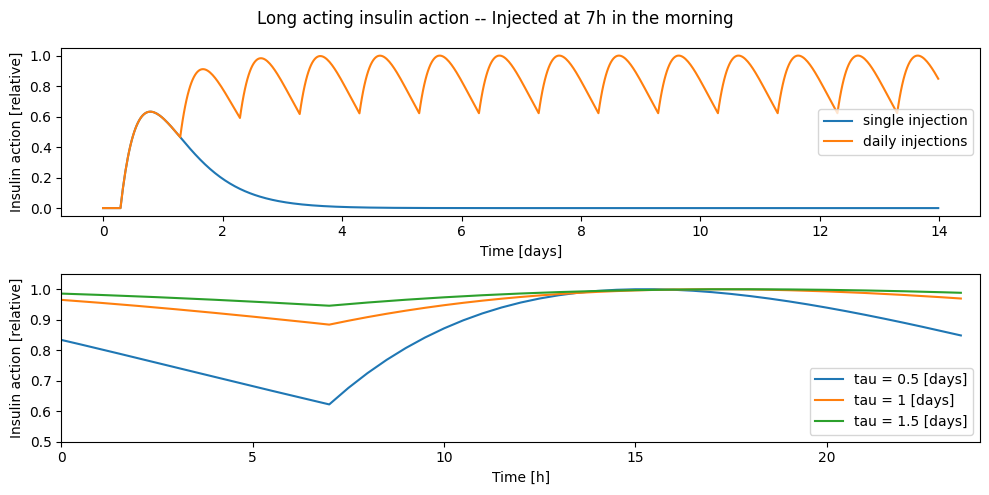

In [7]:
def theta(x):
    # I use a smooth version of the heaviside function to avoid tripping the fit algorithm.
    scale = 0.01
    return (np.tanh(x/scale)+1)/2

def long_insulin_action(t,tau, t0 = 7*60):
    # This is the long acting insulin action. I multiply it by tau so that is has the same units as the glycemia [mmol/l].
    return tau*(t-t0)*theta(t-t0)*np.exp(-(t-t0)/tau)/(tau**2)

def create_action_curve(nb_days, tau):
    time = np.arange(0,nb_days*24*60,30)
    action = long_insulin_action(time, tau)
    for d in np.arange(1,nb_days):
        action += long_insulin_action(time,tau,7*60+24*60*d)
    max_action = action.max()
    min_action = action[time > (nb_days-1)*24*60].min()
    action = action/max_action
    return time, action, max_action, min_action

fig, axs = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(10)

relative_effect = pd.DataFrame([],index = [0.5,1,1.5], columns = ['Relative daily insulin action decrease %'])
relative_effect.index.name = 'Action time scale [days]'

nb_days = 14
tau =24*0.5*60
time, action, max_action, min_action = create_action_curve(nb_days, tau)
axs[0].plot(time/(24*60),long_insulin_action(time,tau)/max_action, label = 'single injection')
axs[0].plot(time/(24*60),action, label = 'daily injections')
axs[1].plot(time/(60)-13*24,action, label = 'tau = 0.5 [days]')
relative_effect.loc[0.5,'Relative daily insulin action decrease %'] = round(100*min_action/max_action,2)

tau =24*60
time, action, max_action, min_action = create_action_curve(nb_days, tau)
axs[1].plot(time/(60)-13*24,action, label = 'tau = 1 [days]')
relative_effect.loc[1,'Relative daily insulin action decrease %'] = round(100*min_action/max_action,2)

tau =24*1.5*60
time, action, max_action, min_action = create_action_curve(nb_days, tau)
axs[1].plot(time/(60)-13*24,action, label = 'tau = 1.5 [days]')
relative_effect.loc[1.5,'Relative daily insulin action decrease %'] = round(100*min_action/max_action,2)

axs[1].set_ylim([0.5,1.05])
axs[1].set_xlim([0,24])

axs[0].set_xlabel('Time [days]')
axs[1].set_xlabel('Time [h]')
axs[0].set_ylabel('Insulin action [relative]')
axs[1].set_ylabel('Insulin action [relative]')
axs[0].legend()
axs[1].legend()
fig.suptitle('Long acting insulin action -- Injected at 7h in the morning')
fig.tight_layout();
display(relative_effect)

The above figure suggest that it is better to inject the long acting insulin in the evening. Indeed, taking my daily long acting insulin shot in the evening should enable me to slightly decrease my dose because the peak of the insulin action (in the case of daily shots) happens about 8 hours after the shot. By taking the shot in the evening, I have a stronger insulin action during the night (period of low physical activity) and a weaker action during the day (more activity). Then my glycemia should not go up during the night and I should need less snacks (glucose corrections) during the day.

It currently not possible to relate the slow drift amplitude to the number of doses of slow acting insulin. I can only decrease the dose incrementally until I hit a sweet spot. I have made the change (from injecting at 7h to 19h) while writing this document and had to then decrease my long acting insulin by two doses (from 16 to 14 doses). It is however not clear how much of that decrease is just correcting my original over-dose and how much is due to the change in the time of the shot.

## 6. Summary

This project has provided many useful measurements concerning the insulin and glucose action. In particular, committing the following data to memory will help with my treatment.

In [2]:
import pandas as pd
temp = pd.concat([pd.read_csv('insulin_action_1.csv')])
temp = temp.drop(columns = ['Event start','mae [mmol/l]', 'rmse [mmol/l]', 'Slow drift [mmol/(lh)]', 'Action time scale [minutes]'])
temp['number of doses'] = 3
temp['Total glycemia decrease per dose [mmol/l]'] = temp['Total glycemia decrease [mmol/l]']/temp['number of doses']
temp = temp.set_index('number of doses')
temp.columns.name = 'Rapid insulin action'
round(temp,1)

Rapid insulin action,Action delay [minutes],Total glycemia decrease [mmol/l],Time to 20% [hours],Time to 80% [hours],Total glycemia decrease per dose [mmol/l]
number of doses,,,,,
3,28.5,4.9,1.0,2.5,1.6


The insulin action is completely invisible in the first 30 minutes after injection. It's effect only starts to be really noticeable after 1 hour. It takes about 2.5 hours for the insulin to entirely take effect. Every dose will lower my glycemia by 1.6 [mmol/l].

I made very similar measurements about the glucose action curve.

In [3]:
temp = pd.read_csv('glucose_action_1.csv')
temp['glucose amount [g]'] = [10,10,10]
temp['glucose type'] = ['sugar', 'chocolate', 'sugar']
temp = temp.set_index('glucose amount [g]')
temp = temp.drop(columns = ['EventType','Event start','mae [mmol/l]', 'rmse [mmol/l]', 'Slow drift [mmol/(lh)]', 'Action time scale [minutes]'])
#temp = temp.sort_values('Event start')
temp.loc['mean',['Action delay [minutes]', 'Total glycemia increase [mmol/l]']] = temp.loc[:,['Action delay [minutes]', 'Total glycemia increase [mmol/l]']].mean()
temp.columns.name = 'Glucose action'
round(temp,1)

Glucose action,Action delay [minutes],Total glycemia increase [mmol/l],Time to 20% [hours],Time to 80% [hours],glucose type
glucose amount [g],,,,,
10,21.2,4.5,0.5,1.0,sugar
10,16.9,3.9,0.7,1.8,chocolate
10,17.6,3.6,0.5,1.2,sugar
mean,18.6,4.0,NaN,NaN,NaN


Glucose intakes are invisible for a bit less than 20 minutes. Then they act rapidly. The glycemia starts rising less than 1 hour after intake (30 minutes for sugar and 40 minutes for the chocolate). The effect of the sugar is about 1 hour long while the chocolate takes almost 2 hours to raise the glycemia. For 10 grams of glucose, the glycemia goes up by about 4 [mmol/l].

One dose of insulin decreases my glycemia by about 1.6 [mmol/l] and 10 [g] of glucose raises it by about 4 [mmol/l]. I need 2.5 doses of insulin for every 10 [g] of glucose. This value is much larger than what I expect and am used to. It is possible that I have been compensating the overdosed long acting insulin by under-dosing my rapid acting insulin. Now that my long acting insulin is better dosed, I need to count carbs precisely for a while and see if I need more insulin than expected.

For insulin and glucose action, the action delay is the result of two different contributions:

- The glycemia sensor is actually measuring the glucose concentration in the intersticial fluid (liquid between the cells) and interpolating the glycemia (glucose concentration in the blood) from it. The two measurements are well correlated, but the intersticial fluid lags in time when compared to the glycemia. Glucose needs some time to penetrate the intersticial spaces and become visible for the sensor. I was taught that this delay is about 15 minutes.
- Once insulin is injected or glucose ingested, it takes some time to get to where it is needed and affect the glycemia. This delay is a lot longer for insulin because the shots are taken subcutaneously. Insulin has to travel from the injection site to the entire body before it can be effective.

The first effect is an artefact of the glycemia sensor system. The actual glycemia is what matters. I often feel low glycemia values (and the following return to normal values) before they are registered by the sensor. The second is real and complex. It depends on what goes in, how it gets there and where it has to go. Assuming that the sensor delay is 15 minutes, then the insulin needs about 15 minutes to have is fist effect on the glycemia while glucose starts being effective after 5 minutes only. It is interesting that both types of glucose (white sugar and chocolate) more or less have the same action delay.

## 7. Conclusion and outlook

This is analysis has worked out quite well and has provided explainable results and useful insights. It is however very small. Only 5 events could be analysed in total. All the results discussed above need to be confirmed by repeating the experiment and analysis.

Furthermore, a comparison to scientific literature is currently lacking. How are insulin action times estimated by insulin manufacturers? The above analysis looks quite simple and straightforward to me. Is there a better way? How is the advertised insulin action time defined in the literature?

This is my first project where I analyse my glycemia seriously. The project can be continued in many different ways:
- The very first step is to repeat the experiment identically. This will confirm (or contradict) the current result and provide important estimate of the amount of random variability for the obtained numerical values.
- Next, it would be interesting to repeat the experiment with more people. This will provide an estimation of the amount or variability from one person to another. In particular, since insulin action time scales are advertised by insulin manufacturers, I expect these values to be similar from one person to another. Insulin needs and glucose effects (measured as total glycemia changes here) are however different for every one. Checking these two qualitative claims (identical insulin action times and different insulin needs) will provide an additional test of the current understanding.
- It would be interesting to look at the slow drift in a lot more detail. In particular, removing all the physical exercise from the experiment would remove a large portion of the variability of $C$. Then it may be possible to observe variations in the slow drift as the day goes by. I expect some kind of correlation with sleep patterns and thus daily changes. Measuring this could be directly used to set up an insulin pump.
- I assume that the decrease in glycemia from each dose of insulin is the same. This could be tested by measuring this quantity for increasingly large doses of insulin.
- I assume that the insulin action does not depend on the current value of the glycemia even though this is not the case for low values. This effect is difficult to investigate because low glycemia values are uncomfortable and dangerous. It could however be instructive to compare the action of identical doses of insulin with different (high enough) values of the initial glycemia.

Once the above questions are under control, I can look into the following more involved questions.
- I would like to better understand the effect of exercise on the glycemia. This is difficult here because it looks like this effect is strongly coupled to the effect of insulin. If I can understand well the effect of insulin, then I can see how it is modified by exercise. An interesting model would be to multiply the insulin action by some kind of exercise factor that varies around one. If the factor is bigger than one, then the inulin effect is boosted and if it's smaller than one, then it's hindered.
- It must be possible to combine the effects of insulin, glucose and exercise to model a normal (non fasting) day. There would be quite a lot of parameters and the glucose intake would have to be closely logged, but a lot more data would be available since no fasting is required. If it is is possible to measure the parameters of the different components independently, then the full model can be assembled and used directly on real data.
- It may be easier to build a predictive glycemia model by using machine learning methods. These are often difficult to interpret, but can be very powerful.

A model capable of predicting the glycemia a few ours in the future could be useful in a closed loop system. For example, the system could use the model to virtually try out different insulin doses and their delivery schedules and then pick the optimal one for the user.